In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib
import numdifftools as nd
from math import *
from puwr import tauint, correlated_data
%matplotlib inline

In [2]:
def misfitwithH(x,y,func):
    err_width = 0.1
    m = func(x)
    diff = (np.array(m[0])-np.array(y))
    return (np.dot(diff,diff))/(2*err_width**2), m[1]

def misfit(x,y,func):
    err_width = 0.1
    m = func(x)
    diff = (np.array(m)-np.array(y))
    return (np.dot(diff,diff))/(2*err_width**2)

In [3]:
B = 10
N = 1000
t_init = 0
t_end = 10
dt = float(t_end - t_init)/N
rt = np.sqrt(dt)
p_init = 0
kron = np.identity(N)

def f(p):
    return 10*p*(1 - p**2)/(1 + p**2)
    
def fgrad(p):
    return (-10)*(p**4 + 4*p**2 - 1)/((1+p**2)**2)

In [4]:
def Euler(x):
    ts    = np.arange(t_init, t_end, dt)
    ps    = np.zeros(N)
    obvss = np.arange(t_init+0.5, t_end+0.5, 0.5)
    obvs  = []

    ps[0] = p_init
    
    for i in range(1, ts.size):
        t = (i-1) * dt
        p = ps[i-1]
        ps[i] = p + f(p)*dt + rt*x[i-1]
         
        # Extraction Operator
        if (i%(N/20) == 0):
            obvs.append(ps[i])
            
    obvs.append(ps[-1])
        
    return(np.array(obvs))

def EulerwithGrad(x):
    ts    = np.arange(t_init, t_end, dt)
    ps    = np.zeros(N)
    obvss = np.arange(t_init+0.5, t_end+0.5, 0.5)
    obvs  = []
    gs    = np.zeros((N,N))
    
    ps[0] = p_init
    
    
    for i in range(1, ts.size):
        t = (i-1) * dt
        p = ps[i-1]
        ps[i] = p + f(p)*dt + rt*x[i-1]
        
        for k in range(ts.size):
            g = gs[i-1,k]
            gs[i,k] = g + fgrad(p)*g*dt + rt*kron[i,k]

        
    return(ps[20::int(N/20)],gs[20::int(N/20),:])
         
    

# Test
def lipriorreturn(x,A,B):
    return (A@x) + (B@np.random.randn(len(x)))

def pCNRW(x,a,Ir):
    return a*x + (np.sqrt(1-a**2))*np.random.randn(len(x))


In [52]:
def forli(H,t):
    eigenValues, eigenVectors = np.linalg.eigh(H)
    idx = eigenValues.argsort()[::-1]   
    Dr = eigenValues[idx]
    P = eigenVectors[:,idx]
    
    Dr = [i for i in Dr if (i > 0.00001)]
    size = len(Dr)
    P = P[0:size]
    Ir = np.eye(size)
    
    Dr = np.diag(Dr)               
    Da = (np.linalg.inv(2*Ir + t*Dr))@(2*Ir - t*Dr)
    Db = (Ir - Da**2)
    Db[Db < 0] = 0
    Db = np.sqrt(Db)
    a = (2 - t)/(2 + t)
    b = np.sqrt(1 - a**2)
    A = (P.T)@(Da - a*Ir)@np.conj(P) + a*np.eye(1000)
    B = (P.T)@(Db - b*Ir)@np.conj(P) + b*np.eye(1000)
    
    return A,B

In [6]:
def MHpcnrwH(niter, start, proposal, pdf, t, forward):
    
    # Define synthetic data
    np.random.seed(2)
    y = forward(np.random.rand(1000))[0] + 0.01*np.random.rand(20)
    
    # Generate initial point & data matrix
    naccept = 0
    x = [0]*niter
    x[0] = start
    a = (2 - t)/(2 + t)
    Ir = np.eye(1000)
    H = np.zeros((N,N))
    # Metropolis Hastings
    for i in np.arange(1,niter):
        
        current = x[i-1]
        
        
        # Proposal
        proposed = proposal(current,a,Ir)
        
        nafterwithH  = misfitwithH(proposed,y,forward)
        nafter = nafterwithH[0]
        jac = nafterwithH[1]
        nbefore = misfit(current,y,Euler)
        H = H + ((np.conj(jac.T))@(100*np.eye(20)))@jac
        
        #if (i == 100):
         #   H = np.zeros((N,N))
        
        A = min([1,np.exp(nbefore - nafter)])
        u = np.random.uniform()
        
        if (u<A):
            x[i] = proposed
            naccept += 1
        else:
            x[i] = current
            
    print(naccept)
    return np.array(x), H/niter, y

In [13]:
def MHpcnrwint(niter, start, proposal, pdf, t, forward):
    
    # Define synthetic data
    np.random.seed(1)
    y = Euler(np.random.randn(1000)) + 0.01*np.random.randn(20)
    l = y
    
    # Generate initial point & data matrix
    naccept = 0
    counter = 0
    x = [0]*niter
    x[0] = start
    a = (2 - t)/(2 + t)
    Ir = np.eye(1000)
    H = np.zeros((N,N))
    
    intH = niter/1000
    # Metropolis Hastings
    for i in np.arange(1,niter):
        
        current = x[i-1]
        
        
        # Proposal
        proposed = proposal(current,a,Ir)
        

        nbefore = misfit(current,y,Euler)
        nafter  = misfit(proposed,y,Euler)
        
        if (i%50==0):
            nk = misfitwithH(proposed,y,forward)
            nafter = nk[0]
            jac = nk[1]
            H = H + ((np.conj(jac.T))@jac)*100
            counter += 1
            
        A = min([1,np.exp(nbefore - nafter)])
        u = np.random.uniform()
        
        if (u<A):
            x[i] = proposed
            naccept += 1
            
        else:
            x[i] = current
            
    print(naccept)
    print(counter)
    return np.array(x), (H/counter), l

In [14]:
start = np.random.rand(1000)

In [15]:
l = MHpcnrwint(10000, start, pCNRW, misfit, 0.01, EulerwithGrad)

3396
199


In [16]:
l[1]

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 8.18307692, 7.46675953, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 7.46675953, 6.81328504, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [17]:
def MHpcnrw(niter, start, proposal, pdf, t, y):

    # Generate initial point & data matrix
    naccept = 0
    x = [0]*niter
    x[0] = start
    a = (2 - t)/(2 + t)
    Ir = np.eye(200)
    # Metropolis Hastings
    for i in np.arange(1,niter):
        
        current = x[i-1]
        
        # Proposal
        proposed = proposal(current,a,Ir)

        k = min([1,np.exp(pdf(current,y,Euler) - pdf(proposed,y,Euler))])
        u = np.random.uniform()

        if (u<k):
            x[i] = proposed
            naccept += 1
        else:
            x[i] = current
            
    print(naccept)
    return np.array(x)

In [76]:
def MHtestli(niter, start, proposal, pdf, t, forward,H,y):
    
    # Define synthetic data
    j,B = forli(H,t)
    a = (2 - t)/(2 + t)
    Ir = np.eye(200)
    # Generate initial point & data matrix
    naccept = 0
    x = [0]*niter
    x[0] = start
    # Metropolis Hastings
    for i in np.arange(1,niter):
        
        current = x[i-1]
        
        # Proposal
        proposed = proposal(current,j,B)

        A = min([1,np.exp(pdf(current,y,forward) - pdf(proposed,y,forward))])
        u = np.random.uniform()

        if (u<A):
            x[i] = proposed
            naccept += 1
        else:
            x[i] = current
            
        if ((i%50)==0):
            nk = misfitwithH(proposed,y,EulerwithGrad)
            jac = nk[1]
            H = (H + ((np.conj(jac.T))@jac)*100)/2
            j,B = forli(H,t)
            
    print(naccept)
    return np.array(x),y

In [37]:
a = MHpcnrw(200000, start, pCNRW, misfit, 0.01, l[2])

68315


In [48]:
a.shape

(200000, 1000)

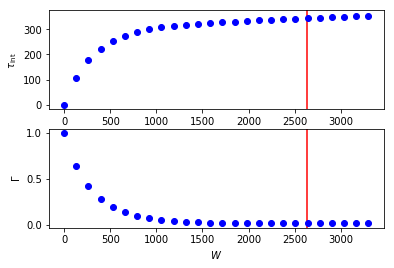

mean = -0.005891103001977523 +/- 0.0018499337827217641
tau_int = 344.2497000224045 +/- 2.33036975834604


In [49]:
mean, delta, tint, d_tint = tauint([a.T], 0, plots=True)
print ("mean = {0} +/- {1}".format(mean, delta))
print ("tau_int = {0} +/- {1}".format(tint, d_tint))

In [77]:
x = MHtestli(200000, start, lipriorreturn, misfit, 0.01, Euler, l[1],l[2])

58977


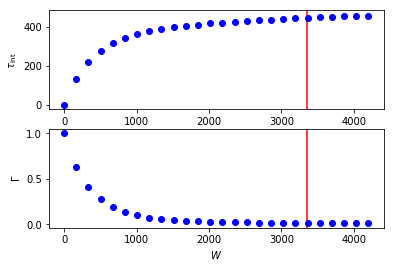

mean = -0.004684128685424967 +/- 0.0021101260080632882
tau_int = 446.45522118055163 +/- 3.405399808840535


In [78]:
mean, delta, tint, d_tint = tauint([x[0].T], 0, plots=True)
print ("mean = {0} +/- {1}".format(mean, delta))
print ("tau_int = {0} +/- {1}".format(tint, d_tint))

In [ ]:
plt.plot(a)

In [ ]:
plt.plot(a[3000:])

In [64]:
def MHtestliwithup(niter, start, proposal, pdf, t, forward,H,y):
    
    # Define synthetic data
    j,B = forli(H,t)
    
    # Generate initial point & data matrix
    naccept = 0
    x = [0]*niter
    x[0] = start
    # Metropolis Hastings
    for i in np.arange(1,niter):
        
        current = x[i-1]
        
        # Proposal
        proposed = proposal(current,j,B)
        
        if (i%50==0):
            nafterwithH  = misfitwithH(proposed,y,forward)
            nafter = nafterwithH[0]
            jac = nafterwithH[1]
            nbefore = misfit(current,y,Euler)
            H = ((np.conj(jac.T))@jac)*100
            j,B = forli(H,t)
        
        else:
            nbefore = misfit(current,y,Euler)
            nafter  = misfit(proposed,y,Euler)


        A = min([1,np.exp(nbefore - nafter)])
        u = np.random.uniform()

        if (u<A):
            x[i] = proposed
            naccept += 1
        else:
            x[i] = current
            
    print(naccept)
    return np.array(x),y

In [ ]:
def forli(H,t):
    eigenValues, eigenVectors = np.linalg.eigh(H)
    idx = eigenValues.argsort()[::-1]   
    Dr = eigenValues[idx]
    P = eigenVectors[:,idx]
    
    Dr = [i for i in Dr if (i > 0.0001)]
    size = len(Dr)
    P = P[0:size]
    Ir = np.eye(size)
    
    Dr = np.diag(Dr)               
    Da = (np.linalg.inv(2*Ir + t*Dr))@(2*Ir - t*Dr)
    Db = (Ir - Da**2)
    Db[Db < 0] = 0
    Db = np.sqrt(Db)
    a = (2 - t)/(2 + t)
    b = np.sqrt(1 - a**2)
    A = (P.T)@(Da - a*Ir)@np.conj(P) + a*np.eye(1000)
    B = (P.T)@(Db - b*Ir)@np.conj(P) + b*np.eye(1000)
    
    return A,B

In [20]:
j,B = forli(l[1],0.01)

In [88]:
eigenValues, eigenVectors = np.linalg.eigh(l[1])
idx = eigenValues.argsort()[::-1]   
Dr = eigenValues[idx]
P = eigenVectors[:,idx]
    
Dr = [i for i in Dr if (i > 0.1)]
size = len(Dr)
P = P[0:size]
Ir = np.eye(size)

In [89]:
len(Dr)

51

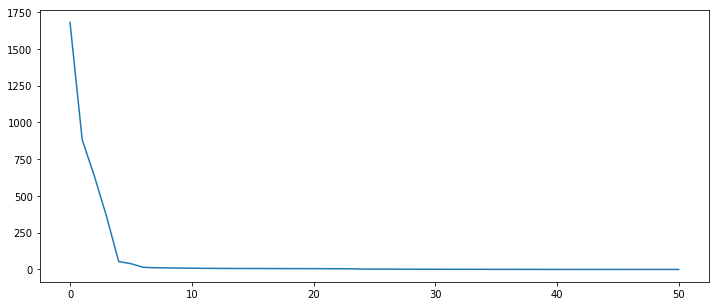

In [102]:
plt.figure(figsize = (12,5))
plt.plot(Dr)

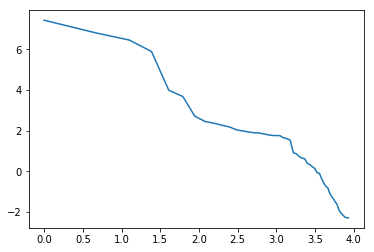

In [101]:
plt.plot([log(n) for n in np.arange(1,52)],[log(x) for x in Dr])

In [32]:
Dr

[1680.9546297150537,
 882.343130473416,
 635.2841476150065,
 361.1280367430204,
 53.78748794935568,
 39.332520965812044,
 14.96534280063183,
 11.520923207963321,
 10.558618643725625,
 9.519199403151081,
 8.757757594073011,
 7.637102413685016,
 7.236783989082789,
 6.897069103521191,
 6.617503350491189,
 6.549995171822237,
 6.265992886260512,
 5.992861544316439,
 5.792419136127047,
 5.763791468665091,
 5.7547975421042015,
 5.18715912208152,
 4.951031950790648,
 4.601354315064611,
 2.482915624187103,
 2.3510601591815368,
 2.0465798757254845,
 1.9033663567068348,
 1.8303468538759236,
 1.452872734167819,
 1.3840160126977092,
 1.240605082024607,
 1.1355610016141924,
 0.9198381269810433,
 0.9029912520365925,
 0.6935998535909776,
 0.5630714393616636,
 0.4762266392246469,
 0.44306276784339654,
 0.3378221682266609,
 0.2855643698787397,
 0.25430665387398715,
 0.21922770137554232,
 0.1935182227557875,
 0.1510389897990922,
 0.1299939984597138,
 0.11944815068503137,
 0.10947289095787474,
 0.10260206